In [2]:
import pandas as pd
import numpy as np
import pandasql as ps
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pyhive import presto
from pymongo import MongoClient
import warnings
warnings.filterwarnings("ignore")

presto_conn = presto.connect(
    host='presto.processing.yoda.run',
    port=80,
    protocol='http',
    catalog='hive',
    username='mayank.jha@rapido.bike',
    # requests_kwargs=req_kw,
)

In [595]:
start_date = '2021-08-30'
end_date = '2021-09-19'
city = 'Hyderabad'

In [21]:
pd.to_datetime('2021-09-12').strftime('%Y-%V')

'2021-36'

# Fetch ratings and Rides for captains week on week

In [596]:
# Rides & Ratings

rides_query = """SELECT rider,
                    CAST(DATE_TRUNC('week',CAST(orderdate AS DATE)) as varchar) as order_week,
                    COUNT(DISTINCT(orderdate)) as wdays,
                    COUNT(DISTINCT(_id)) as rides,
                    -- avg(case when feedback_customerrating = -1 then 5 else feedback_customerrating end) as rating
                    coalesce(sum(case when feedback_customerrating = -1 then 0 else feedback_customerrating end)/(nullif(sum(case when feedback_customerrating = -1 then 0 else 1 end),0)*1.0),0) as rating
                    from legacy.orders
                    where orderdate >= '{sd}'
                    and orderdate <= '{ed}'
                    and status = 'dropped'
                    and spdfraud_flag != 1
                    and serviceobj_city = '{ct}'
                    group by 1, 2""".format(sd=start_date, ed= end_date, ct = city)

df_rides = pd.read_sql(rides_query, presto_conn)
df_rides.head()

,rider,order_week,wdays,rides,rating
0,5e1597612e9bc35b37bda3d1,2021-08-30,4,20,4.8
1,5c84fbde5e042733c9c6e8bd,2021-09-13,3,26,4.2
2,60c0258d29a694210cb80df2,2021-09-06,3,4,5.0
3,5fbbbfdf7e483f18a5fde585,2021-09-06,5,104,4.5
4,5ff959bb87d7415f93219589,2021-08-30,6,15,3.9


In [597]:
df_rides['week'] = pd.to_datetime(df_rides['order_week'])
df_rides['week'] = df_rides['week'].apply(lambda x : x.strftime('%Y-%V')[-2:]).apply(pd.to_numeric)
df_rides.drop(['order_week'],axis = 1, inplace=True)
df_rides.head()

,rider,wdays,rides,rating,week
0,5e1597612e9bc35b37bda3d1,4,20,4.8,35
1,5c84fbde5e042733c9c6e8bd,3,26,4.2,37
2,60c0258d29a694210cb80df2,3,4,5.0,36
3,5fbbbfdf7e483f18a5fde585,5,104,4.5,36
4,5ff959bb87d7415f93219589,6,15,3.9,35


In [599]:
# Commission and Discount

def get_commission_discount(start_date, end_date, city):
    print("fetching commission and discount for : ",start_date," to ", end_date)
    orders_query = """   select riderid,
        week,
        sum(cast(commission as double)) as commission,
        sum(cast(discount as double)) as discount
    from
        (select distinct riderid, 
                CAST(WEEK(DATE(date_parse(yyyymmdd,'%Y%m%d'))) as int) as week, 
                orderid, 
                orderslabdata_payoutcommission as commission, 
                orderslabdata_discount as discount
            from raw.mongodb_rapidopayroll_riderspaymentnew_immutable 
            where status = 'success' 
                and transactionType = 'orders' 
                and yyyymmdd between '{sd}' and '{ed}'
                and city = '{ct}'
        )
    group by 1,2              
               """.format(sd = start_date.replace('-',''), ed = end_date.replace('-',''), ct = city)


    df_cd = pd.read_sql(orders_query, presto_conn)
    
    print(" fetched commission and discount", len(df_cd))

    return df_cd

df_commission = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list : 
    commission = get_commission_discount(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'), city)
    x = pd.to_datetime(day).strftime('%Y-%V')
    commission['week'] = x[-2:]
    commission['week'] = commission['week'].apply(pd.to_numeric)
    df_commission = pd.concat([df_commission,commission])

df_commission.head()

fetching commission and discount for :  2021-08-30  to  2021-09-05
 fetched commission and discount 28670
fetching commission and discount for :  2021-09-06  to  2021-09-12
 fetched commission and discount 29495
fetching commission and discount for :  2021-09-13  to  2021-09-19
 fetched commission and discount 30459


,riderid,week,commission,discount
0,5c913f168c352421eaf2ca35,35,24.754,0.0
1,60eec6aafa195c4f6da1e3a5,35,242.315,146.0
2,5de20a6eac56a62ec5e22123,35,234.205,63.0
3,5e31475ff82b3dd531eb25bd,35,318.455,133.0
4,5fc5f25fc5ea9e878937251a,35,0.000,705.0


In [600]:
final_data = df_rides.merge(df_commission, how = 'left', left_on = ['rider','week'], right_on = ['riderid','week'])
final_data.drop(['riderid'], axis = 1, inplace = True)
final_data.head()

,rider,wdays,rides,rating,week,commission,discount
0,5e1597612e9bc35b37bda3d1,4,20,4.8,35,176.512,50.0
1,5c84fbde5e042733c9c6e8bd,3,26,4.2,37,119.184,30.0
2,60c0258d29a694210cb80df2,3,4,5.0,36,0.000,0.0
3,5fbbbfdf7e483f18a5fde585,5,104,4.5,36,662.354,161.0
4,5ff959bb87d7415f93219589,6,15,3.9,35,0.000,95.0


# Fetch login hours for captains week on week

In [598]:
# Login hours

def get_login_hours(start_date, end_date, city):
    print("fetching Login hours for : ",start_date," to ", end_date)
    orders_query = """   SELECT 
        userid as rider, 
        --CAST(WEEK(DATE(date_parse(yyyymmdd,'%Y%m%d'))) as int) as week,
        --date_format(date_parse(yyyymmdd, '%Y%m%d'), '%Y-%m-%d') AS logindate, 
        cast(sum(duration) as double)/cast((60*60*1000) as double) as login_hours
        FROM hive.datasets.captain_login_hours
        WHERE yyyymmdd >= '{sd}' AND yyyymmdd <= '{ed}'
        AND status in ('2','3','6','7','8','10')
        AND userid in (SELECT captainId from datasets.captain_single_view WHERE upper(registeredcity) = upper('{ct}')  AND activationdate is not null)
        GROUP BY 1                
               """.format(sd = start_date.replace('-',''), ed = end_date.replace('-',''), ct = city)


    df_lh = pd.read_sql(orders_query, presto_conn)
    
    print(" fetched Login hours", len(df_lh))

    return df_lh

df_login_hours = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list : 
    login_hours = get_login_hours(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'), city)
    x = pd.to_datetime(day).strftime('%Y-%V')
    login_hours['week'] = x[-2:]
    login_hours['week'] = login_hours['week'].apply(pd.to_numeric)
    df_login_hours = pd.concat([df_login_hours,login_hours])

df_login_hours.head()

fetching Login hours for :  2021-08-30  to  2021-09-05
 fetched Login hours 42180
fetching Login hours for :  2021-09-06  to  2021-09-12
 fetched Login hours 43470
fetching Login hours for :  2021-09-13  to  2021-09-19
 fetched Login hours 45745


,rider,login_hours,week
0,5dedbc0a1a882e3354b98d2b,4.614324,35
1,5dfc42b2dc631c72b9f92474,0.042046,35
2,5f0ee35f702226543d9ad75c,3.974916,35
3,5fad18bc7afaf56ebb461b60,3.691290,35
4,5d53b38cbde10e0d543d90e2,9.543003,35


In [601]:
final_data = final_data.merge(df_login_hours, how = 'left', left_on = ['rider','week'], right_on = ['rider','week'])
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours
0,5e1597612e9bc35b37bda3d1,4,20,4.8,35,176.512,50.0,15.201046
1,5c84fbde5e042733c9c6e8bd,3,26,4.2,37,119.184,30.0,15.679589
2,60c0258d29a694210cb80df2,3,4,5.0,36,0.000,0.0,17.017137
3,5fbbbfdf7e483f18a5fde585,5,104,4.5,36,662.354,161.0,63.177167
4,5ff959bb87d7415f93219589,6,15,3.9,35,0.000,95.0,29.530491


# Fetch Earnings for captains week on week

In [602]:
# Earnings

def get_earnings():

    orders_query = """   
    select riderid, 
        week,
        sum(amount) as orders_earnings
    from
        (select distinct riderId as riderid,
                orderid,
                CAST(WEEK(DATE(date_parse(yyyymmdd,'%Y%m%d'))) as int) as week,
                cast(amount as double) as amount 
            from raw.mongodb_rapidopayroll_riderspaymentnew_immutable
            where yyyymmdd between '{sd}' and '{ed}'
                and city = '{ct}' 
                and transactionType = 'orders' 
                and status = 'success'
        )
    group by 1,2
               """.format(sd = start_date.replace('-',''), ed = end_date.replace('-',''), ct = city)
    df_orders_data = pd.read_sql(orders_query, presto_conn)
    return df_orders_data

df_earnings = get_earnings()
df_earnings.head()

,riderid,week,orders_earnings
0,5cdba764377155163cfa82f4,37,1046.49
1,5f671ce594f7daf30724dec7,37,2680.55
2,5dde5f2936ec3d26ae281fe3,37,3130.80
3,5cda9ccc377155163cf9d7cd,37,3115.07
4,5d7ba848a24c96105e4bcf2e,37,610.63


In [603]:
final_data = final_data.merge(df_earnings, how = 'left', left_on = ['rider','week'], right_on = ['riderid','week'])
final_data.drop(['riderid'], axis = 1, inplace=True)
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings
0,5e1597612e9bc35b37bda3d1,4,20,4.8,35,176.512,50.0,15.201046,1176.73
1,5c84fbde5e042733c9c6e8bd,3,26,4.2,37,119.184,30.0,15.679589,1274.55
2,60c0258d29a694210cb80df2,3,4,5.0,36,0.000,0.0,17.017137,315.41
3,5fbbbfdf7e483f18a5fde585,5,104,4.5,36,662.354,161.0,63.177167,4337.36
4,5ff959bb87d7415f93219589,6,15,3.9,35,0.000,95.0,29.530491,1464.40


# Fetch APR, CR for captains week on week

In [608]:
# APR and CR and OCARA

# Fetch the Cancel Rate Data

def get_pings(sdate, edate, city):

    dpr_query = """
                with orders 
    as 
    (
        SELECT
        *, 
        case when test_order_status='onTheWay' and order_status='customerCancelled' and cancel_reason = 'Taking longer than expected' and time_diff > fe_eta then 1 else 0 end as long_flag
        from 
        (
        SELECT 
        order_id,
        city_name, 
        captain_obj_mobile,
        captain_id, 
        case when array_distinct(array_agg(captain_id) over (partition by order_id order by updated_epoch)) is null then 0 else cardinality(array_distinct(array_agg(captain_id) over (partition by order_id order by updated_epoch))) - 1 end  as ping_captains1,
        DATE_FORMAT(FROM_UNIXTIME(ROUND(updated_epoch/ 1000), 'Asia/Kolkata'), '%Y-%m-%d %H:%i:%s')  as  ds,
        event_type, 
        lag(DATE_FORMAT(FROM_UNIXTIME(ROUND(updated_epoch/ 1000), 'Asia/Kolkata'), '%Y-%m-%d %H:%i:%s'))  over (partition by order_id order by updated_epoch) as test_ds,
        (updated_epoch -  lag(updated_epoch) over (partition by order_id order by updated_epoch))/1000 as time_diff,
        lag(order_status)  over (partition by order_id order by updated_epoch) as test_order_status,
        order_status, 
        cancel_reason,
        case when event_type = 'accepted' then 1 else 0 end accepted_flag,
        case when event_type = 'rider_cancelled' then 1 else 0 end rc_flag,
        case when event_type = 'rider_busy' then 1 else 0 end as rb_flag,
        case when event_type = 'rider_reject' then 1 else 0 end as  rj_flag,
        case when event_type = 'customer_cancelled' and cancel_reason IN ('Drop location denied', 'Vehicle / Safety issues', 'Asked to cancel & take offline ride', 'Asked to cancel', 'Captain Asking to pay extra' )  then 1 else 0 end as cc_flag, 
        case when event_type = 'dropped' then 1 else 0 end as  net_flag,
        case when event_type in ('rider_busy', 'rider_reject', 'accepted') then 1 else 0 end as total_pings,
        eta*60 as fe_eta
        from 
        orders.order_logs_immutable 
        where 1=1 
        and yyyymmdd >= '{sd}'
        and yyyymmdd <= '{ed}'
        and city_name = '{city}'
        )
    )



    --  Taking longer than expected where OTW ETA < time to cancel 

     ,customer_contact_captain 
    AS 
    (

    SELECT 
            * FROM 
            (
                SELECT eventprops_orderid,
                eventprops_screen ,
                eventProps_captainid,
                eventprops_orderid as customer_contact_captain_id ,
                ROW_NUMBER() OVER (PARTITION BY eventprops_orderid  ORDER BY epoch desc) AS Rank_
                FROM  raw.clevertap_customer_callrider 
                where 
                1=1           
                and
                length(eventprops_orderid)>=2
                -- AND 
                -- eventProps_orderType='B2C'
                AND 
                raw.clevertap_customer_callrider.yyyymmdd >= '{sd}'
                AND raw.clevertap_customer_callrider.yyyymmdd <= '{ed}'
                ORDER BY 1

            )
    WHERE Rank_=1

    )


    ,captain_contact_customer 
    AS 
    (

    SELECT 
            * FROM 
            (
                SELECT eventprops_orderid, 
                eventprops_context ,
                eventprops_orderid as captain_contact_customer_id,
                profile_identity,
                profile_phone, 
                ROW_NUMBER() OVER (PARTITION BY eventprops_orderid  ORDER BY epoch desc) AS Rank_
                FROM  raw.clevertap_captain_callcustomer 
                where 
                1=1           
                and
                length(eventprops_orderid)>=2
                AND
                raw.clevertap_captain_callcustomer.yyyymmdd >= '{sd}'
                AND raw.clevertap_captain_callcustomer.yyyymmdd <= '{ed}'
                ORDER BY 1
            )
    WHERE Rank_=1

    )


    ,captain_info
    AS 
    (

            select 
            orders.city_name, 
            orders.captain_id, 
            sum(case when  (cc_flag=1 and (customer_contact_captain.customer_contact_captain_id is not null or captain_contact_customer.captain_contact_customer_id is not null) 
                and (eventProps_captainid is not null or captain_contact_customer.profile_identity is not null))  then 1 else 0 end) as cc_flag_call_pings, 
            sum(net_flag) as Net, 
            sum(accepted_flag) as Accepted_pings,
            sum(rc_flag) RiderCancelled_pings , 
            sum(rb_flag) as RiderBusy_pings, 
            sum(rj_flag) as RiderReject_Pings, 
            sum(total_pings) as total_pings, 
            sum(long_flag) as long_flag
            FROM 
            orders left join customer_contact_captain on customer_contact_captain.customer_contact_captain_id = orders.order_id 
                                                    and customer_contact_captain.eventProps_captainid = orders.captain_id

                  left join captain_contact_customer on captain_contact_customer.captain_contact_customer_id = orders.order_id 
                                                     and substr(captain_contact_customer.profile_phone,-10) = orders.captain_obj_mobile
            where 1=1 
                    and captain_id is not null
            group by 1,2
            -- and orders.cancel_reason != 'Not able to swipe Arrived'
    ) 


    , city_aggr
    as
    (
    select
    city_name, 
    approx_percentile(dpr,(1.00*100)/100) as median_city, 
    (coalesce(TRY((sum(Net)*1.00)/(sum(net) + sum(cc_flag_call_pings) + sum(RiderCancelled_pings) + sum(RiderBusy_pings) + sum(long_flag) + sum(RiderReject_Pings))),0)) as dpr_city , 
    (coalesce(TRY((sum(Net)*1.00)/(sum(total_pings))),0)) as dpr_city_old  

    from
        (
            select 
            city_name,
            captain_info.Net, 
            captain_info.Accepted_pings,
            captain_info.cc_flag_call_pings,
            captain_info.RiderCancelled_pings,
            captain_info.RiderBusy_pings, 
            captain_info.RiderReject_Pings, 
            captain_info.total_pings,
            captain_info.long_flag,
            try(coalesce((((captain_info.Net)*1.00)/((captain_info.net) + (captain_info.cc_flag_call_pings) + (captain_info.long_flag) + (captain_info.RiderCancelled_pings) + (captain_info.RiderBusy_pings) + (captain_info.RiderReject_Pings))),0)) as dpr
            FROM 
            captain_info 
        )
        group by 1 

    )

    -- select * from orders where long_flag=1 

    SELECT 
    captain_info.city_name AS "City",
    captain_info.captain_id, 

    --captain_info.total_pings AS "Total Pings",
    captain_info.Accepted_pings AS "Accepted Pings",
    --captain_info.Net AS "Net", 

    captain_info.cc_flag_call_pings+captain_info.long_flag AS "Captain-induced CC Pings" ,
    captain_info.RiderCancelled_pings AS "Rider Cancelled Pings",
    captain_info.RiderBusy_pings AS "Rider Busy Pings", 
    captain_info.RiderReject_Pings AS "Rider Rejected Pings" 


    --coalesce(TRY((captain_info.Accepted_pings*1.00)/captain_info.total_pings),0) AS "APR", 
    --coalesce(TRY(((captain_info.cc_flag_call_pings+captain_info.long_flag+captain_info.RiderCancelled_pings)*1.00)/(captain_info.cc_flag_call_pings+captain_info.long_flag+captain_info.net+captain_info.RiderCancelled_pings)),0) AS "Cancellation Rate", 
    --(coalesce(TRY(((captain_info.Net)*1.00)/((captain_info.net) + (captain_info.cc_flag_call_pings) + (captain_info.RiderCancelled_pings) + (captain_info.long_flag) + (captain_info.RiderBusy_pings) + (captain_info.RiderReject_Pings))),0)) as "True DPR(Captain)", 
    --(coalesce(TRY(((captain_info.Net)*1.00)/(captain_info.total_pings)),0)) as "Old DPR(Captain)", 



    --dpr_city as "True DPR(City)",
    --city_aggr.dpr_city_old as "Old DPR(City)",
    --city_aggr.median_city as "Nth_percentile City"
    FROM 
    captain_info 
    JOIN city_aggr on city_aggr.city_name = captain_info.city_name 
    where 1=1 
    and median_city >= (coalesce(TRY(((captain_info.Net)*1.00)/((captain_info.net) + (captain_info.cc_flag_call_pings) + (captain_info.RiderCancelled_pings) + (captain_info.RiderBusy_pings) + (captain_info.RiderReject_Pings))),0))

    order by captain_info.city_name,total_pings desc

    -- select * FROM city_agg""".format(sd = sdate, ed = edate, city = city)

    #print(dpr_query)
    df_temp = pd.read_sql(dpr_query, presto_conn)
    return df_temp

In [609]:
date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]

date_list = [x.strftime('%Y-%m-%d') for x in date_list]
date_list

['2021-08-30', '2021-09-06', '2021-09-13']

In [610]:
df_dpr = pd.DataFrame()

for day in date_list : 

    df_temp = get_pings(day.replace('-',''), (pd.to_datetime(day)+timedelta(6)).strftime('%Y%m%d'), city)
    df_temp['week'] = pd.to_datetime(day).strftime('%Y-%V')
    df_dpr = pd.concat([df_dpr,df_temp])

In [611]:
df_dpr['week'] = df_dpr['week'].apply(lambda x : x[-2:]).apply(pd.to_numeric)

In [612]:
df_dpr['cancel'] = (df_dpr['Captain-induced CC Pings']+df_dpr['Rider Cancelled Pings'])/df_dpr['Accepted Pings'] 
df_dpr['cancel'] = df_dpr['cancel'].fillna(0)

#final_data['total_pings'] = final_data['accepted_pings']+final_data['rider_busy_pings']+final_data['rider_rejected_pings']
df_dpr['APR'] = df_dpr['Accepted Pings']/(df_dpr['Accepted Pings']+df_dpr['Rider Busy Pings']+df_dpr['Rider Rejected Pings'])
df_dpr['APR'] = df_dpr['APR'].fillna(0)

df_dpr.head()

,City,captain_id,Total Pings,Accepted Pings,Captain-induced CC Pings,Rider Cancelled Pings,Rider Busy Pings,Rider Rejected Pings,week,cancel,APR
0,Hyderabad,6114c26577eb425efb7fadfe,2685,101,0,0,16,2568,35,0.000000,0.037616
1,Hyderabad,5d72b9e5a24c96105e3d4bc5,2036,111,2,10,207,1718,35,0.108108,0.054519
2,Hyderabad,5f28271b226028467387df3f,1840,54,1,12,515,1271,35,0.240741,0.029348
3,Hyderabad,5f211950ea5a8b6b6f7a37a9,1650,73,1,6,1576,1,35,0.095890,0.044242
4,Hyderabad,606dd25b7761607eee188390,1535,68,2,4,818,649,35,0.088235,0.044300


In [538]:
final_data = final_data.merge(df_dpr[['captain_id','week','APR','cancel']], how = 'left', left_on = ['rider','week'], right_on = ['captain_id','week'])
final_data.drop(['captain_id'], axis = 1, inplace=True)
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel
0,5e3296a47470a94d4ddca065,7,12,4.6,37,146.744,56.0,27.557167,733.72,0.275862,0.250000
1,5cfe7724ca6e292111794ea5,4,32,4.2,37,282.694,168.0,19.543371,1483.47,0.977273,0.093023
2,5d2a072516609737fa4ba0bf,6,51,4.3,37,451.300,283.0,35.501498,2396.50,0.389474,0.094595
3,5fe9b1a94319a7c633b7cd49,6,36,4.5,37,0.000,468.0,33.714429,3125.92,0.257143,0.185185
4,5d34932484e7394e9474299c,3,10,5.0,37,127.048,30.0,9.671801,635.24,0.424242,0.214286


# Fetch OCARA for captains week on week

In [539]:
# Calculate OCARA

ocara_query = """select 
    rider,
    CAST(DATE_TRUNC('week',CAST(orderdate AS DATE)) as varchar) as order_week,
    round(100 * (cast(count(case when ((status != 'dropped') and (status != 'expired') and (cancelreason != 'order cancelled before rider accepted')) then 1 end) as double) / count(_id)), 2) as ocara
from legacy.orders
where 
    orderdate between '{sd}' and '{ed}'
    and serviceobj_city = '{ct}'
group by 1,2 """.format(sd = start_date, ed = end_date, ct = city)

df_ocara = pd.read_sql(ocara_query, presto_conn)
print(len(df_ocara))

9872


In [540]:
df_ocara['week'] = pd.to_datetime(df_ocara['order_week'])
df_ocara['week'] = df_ocara['week'].apply(lambda x : x.strftime('%Y-%V')[-2:]).apply(pd.to_numeric)
df_ocara.drop(['order_week'],axis = 1, inplace=True)
df_ocara.head()

,rider,ocara,week
0,5e54c9600b044839eb9030ae,52.94,37
1,60d82e5c09aa99cfe739f840,16.13,37
2,5cdff3fe25ee3218d4ce10cd,11.54,37
3,60372658f7d42e055b5b3a06,65.52,37
4,5f82b5e94dcf6ee29a642da3,40.00,37


In [541]:
final_data = final_data.merge(df_ocara, how = 'left', left_on = ['rider','week'], right_on = ['rider','week'])
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel,ocara
0,5e3296a47470a94d4ddca065,7,12,4.6,37,146.744,56.0,27.557167,733.72,0.275862,0.250000,52.00
1,5cfe7724ca6e292111794ea5,4,32,4.2,37,282.694,168.0,19.543371,1483.47,0.977273,0.093023,17.50
2,5d2a072516609737fa4ba0bf,6,51,4.3,37,451.300,283.0,35.501498,2396.50,0.389474,0.094595,23.88
3,5fe9b1a94319a7c633b7cd49,6,36,4.5,37,0.000,468.0,33.714429,3125.92,0.257143,0.185185,20.00
4,5d34932484e7394e9474299c,3,10,5.0,37,127.048,30.0,9.671801,635.24,0.424242,0.214286,0.00


In [614]:
# Find the incentive eligible and incentive achieved

def get_incentive_eligible(start_date, end_date, city):
    
    print("fetching eligible incentive for : ",start_date," to ", end_date)

    incentive_eligible = """with incentive as 
            (select distinct _id as incentive_id
                from hive.raw.mongodb_rapidopayroll_incentives_immutable
                where json_array_contains(cities, '{ct}')
                    and startDate between '{sd}' and '{ed}'
                    and endDate between '{sd}' and '{ed}'
            ),
daily_incentive as
            (select riderid,
                    sum(daily_incentive_achieved) as daily_incentive
                from
                    (select distinct riderid,
                            yyyymmdd,
                            tincentiveIdl,
                            subIncentiveId,
                            incentivestage,
                            cast(amount as double) as daily_incentive_achieved
                        from raw.mongodb_rapidopayroll_riderspaymentnew_immutable
                        where incentivetype = 'Daily' 
                            and status = 'success' 
                            and yyyymmdd between '{sd1}' and '{ed1}'
                            and city = '{ct}'
                    ) x
                    join incentive as i
                        on x.tincentiveIdl = i.incentive_id
                group by 1
            ),
weekly_incentive as
            (select riderid,
                    sum(weekly_incentive_achieved) as weekly_incentive
                from
                    (select distinct riderid,
                            yyyymmdd,
                            tincentiveIdl,
                            subIncentiveId,
                            incentivestage,
                            cast(amount as double) as weekly_incentive_achieved
                        from raw.mongodb_rapidopayroll_riderspaymentnew_immutable
                        where incentivetype = 'Weekly Fixed' 
                            and status = 'success' 
                            and yyyymmdd between '{sd1}' and '{ed1}'
                            and city = '{ct}'
                    ) x
                    join incentive as i
                        on x.tincentiveIdl = i.incentive_id
                group by 1
            )
            select coalesce(d.riderid, w.riderid) as riderid,
                d.daily_incentive,
                w.weekly_incentive
            from daily_incentive as d
                full outer join 
                    weekly_incentive as w
                        on d.riderid = w.riderid                    
               """.format(sd = start_date, ed = end_date, sd1 = start_date.replace('-',''), ed1 = end_date.replace('-',''),ct = city)
    
    #print(incentive_eligible)

    df_incentive_eligible = pd.read_sql(incentive_eligible, presto_conn)
    
    print(" fetching incentive eligible captains", len(df_incentive_eligible))

    return df_incentive_eligible

df_incentive_eligible = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list : 
    incentive_eligible = get_incentive_eligible(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'), city)
    x = pd.to_datetime(day).strftime('%Y-%V')
    incentive_eligible['week'] = x[-2:]
    incentive_eligible['week'] = incentive_eligible['week'].apply(pd.to_numeric)
    df_incentive_eligible = pd.concat([df_incentive_eligible,incentive_eligible])

df_incentive_eligible.head()
df_incentive_eligible.to_csv('subscription_incentive_Jaipur.csv', index = False)

fetching eligible incentive for :  2021-08-30  to  2021-09-05
 fetching incentive eligible captains 12250
fetching eligible incentive for :  2021-09-06  to  2021-09-12
 fetching incentive eligible captains 9933
fetching eligible incentive for :  2021-09-13  to  2021-09-19
 fetching incentive eligible captains 9900


In [615]:
final_data = final_data.merge(df_incentive_eligible[['riderid','daily_incentive','weekly_incentive','week']], how = 'left', left_on = ['rider','week'], right_on = ['riderid','week'])
final_data.drop(['riderid'], axis = 1, inplace=True)
final_data.fillna(0, inplace = True)
final_data['total_incentive'] = final_data['daily_incentive'] + final_data['weekly_incentive']
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,City,...,Accepted Pings,Captain-induced CC Pings,Rider Cancelled Pings,Rider Busy Pings,Rider Rejected Pings,cancel,APR,daily_incentive,weekly_incentive,total_incentive
0,5e1597612e9bc35b37bda3d1,4,20,4.8,35,176.512,50.0,15.201046,1176.73,Hyderabad,...,27,0,1,3,1,0.037037,0.870968,75.0,0.0,75.0
1,5c84fbde5e042733c9c6e8bd,3,26,4.2,37,119.184,30.0,15.679589,1274.55,Hyderabad,...,31,2,0,13,5,0.064516,0.632653,200.0,0.0,200.0
2,60c0258d29a694210cb80df2,3,4,5.0,36,0.000,0.0,17.017137,315.41,Hyderabad,...,6,0,1,6,186,0.166667,0.030303,0.0,0.0,0.0
3,5fbbbfdf7e483f18a5fde585,5,104,4.5,36,662.354,161.0,63.177167,4337.36,Hyderabad,...,147,7,6,9,32,0.088435,0.781915,650.0,1000.0,1650.0
4,5ff959bb87d7415f93219589,6,15,3.9,35,0.000,95.0,29.530491,1464.40,Hyderabad,...,26,3,1,130,31,0.153846,0.139037,260.0,0.0,260.0


# Fetch LTR

In [616]:
date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 6]

date_list = [x.strftime('%Y-%m-%d') for x in date_list]
date_list

['2021-09-05', '2021-09-12', '2021-09-19']

In [618]:
# Captain LTR calculation

def get_LTR(dt, city):
    
    captain_ltr_query = """SELECT  captainid, day, sum(lifetimenetrides) as ltr
        from 
        datasets_internal.captain_servicedetail_ridebehavior_immutable_v1 
        WHERE 
        day in (date '{day}')
        --and lastridecity = '{ct}'
        group by 1, 2""".format( day = dt, ct = city)
    
    df_temp = pd.read_sql(captain_ltr_query, presto_conn)
    
    print(" fetching LTR ", len(df_temp))

    return df_temp

captain_ltr = pd.DataFrame()

for day in date_list : 

    df_LTR = get_LTR(day, city)
    captain_ltr = pd.concat([captain_ltr,df_LTR])

captain_ltr.head()

 fetching LTR  1349825
 fetching LTR  1364657
 fetching LTR  1379570


,captainid,day,ltr
0,5e450056308a9fa8a26a362a,2021-09-05,198
1,5f86949ceb17fe243237a508,2021-09-05,99
2,60d7107d09aa993b7c397e37,2021-09-05,17
3,606d72b0e1c0d963ef50b76b,2021-09-05,472
4,5e6b7f8eada7540e0c63b80e,2021-09-05,338


In [619]:
captain_ltr['week'] = pd.to_datetime(captain_ltr['day'])
captain_ltr['week'] = captain_ltr['week'].apply(lambda x : x.strftime('%Y-%V')[-2:]).apply(pd.to_numeric)
captain_ltr.drop(['day'],axis = 1, inplace=True)
captain_ltr.head()

,captainid,ltr,week
0,5e450056308a9fa8a26a362a,198,35
1,5f86949ceb17fe243237a508,99,35
2,60d7107d09aa993b7c397e37,17,35
3,606d72b0e1c0d963ef50b76b,472,35
4,5e6b7f8eada7540e0c63b80e,338,35


In [620]:
final_data = final_data.merge(captain_ltr, how = 'left', left_on = ['rider','week'], right_on = ['captainid','week'])
final_data.drop(['captainid'], axis = 1, inplace=True)
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,City,...,Captain-induced CC Pings,Rider Cancelled Pings,Rider Busy Pings,Rider Rejected Pings,cancel,APR,daily_incentive,weekly_incentive,total_incentive,ltr
0,5e1597612e9bc35b37bda3d1,4,20,4.8,35,176.512,50.0,15.201046,1176.73,Hyderabad,...,0,1,3,1,0.037037,0.870968,75.0,0.0,75.0,175
1,5c84fbde5e042733c9c6e8bd,3,26,4.2,37,119.184,30.0,15.679589,1274.55,Hyderabad,...,2,0,13,5,0.064516,0.632653,200.0,0.0,200.0,47
2,60c0258d29a694210cb80df2,3,4,5.0,36,0.000,0.0,17.017137,315.41,Hyderabad,...,0,1,6,186,0.166667,0.030303,0.0,0.0,0.0,58
3,5fbbbfdf7e483f18a5fde585,5,104,4.5,36,662.354,161.0,63.177167,4337.36,Hyderabad,...,7,6,9,32,0.088435,0.781915,650.0,1000.0,1650.0,1846
4,5ff959bb87d7415f93219589,6,15,3.9,35,0.000,95.0,29.530491,1464.40,Hyderabad,...,3,1,130,31,0.153846,0.139037,260.0,0.0,260.0,134


In [633]:
final_data = final_data.merge(df_captains, how = 'left', left_on = 'rider', right_on = 'captainid')

In [639]:
final_data.to_csv('x.csv', index=False)

In [149]:
df_config = pd.DataFrame(columns=['priority','ltr','rides','rating','cancel'])
df_config = df_config.append(pd.DataFrame([[1,0,0,0,1]],columns=df_config.columns))
df_config = df_config.append(pd.DataFrame([[2,10,10,0.4,0.2]],columns=df_config.columns))
df_config = df_config.append(pd.DataFrame([[3,75,15,0.5,0.15]],columns=df_config.columns))
df_config = df_config.append(pd.DataFrame([[4,120,29,0.6,0.1]],columns=df_config.columns))
df_config

,priority,ltr,rides,rating,cancel
0,1,0,0,0,1
0,2,10,10,0.4,0.2
0,3,75,15,0.5,0.15
0,4,120,29,0.6,0.1


In [150]:
### Including all parameters :


data_sql_query = ps.sqldf("select lt.*, ft.priority from final_data lt left join df_config ft on lt.ltr >= ft.ltr and lt.rides >= ft.rides and lt.rating >= ft.rating and lt.cancel <= ft.cancel")

#max_priority = data_sql_query[data_sql_query['priority'] == data_sql_query['priority'].max()]

df_priority = data_sql_query.groupby(['rider','week']).agg({'priority':'max'}).reset_index()

In [151]:
final_data = final_data.merge(df_priority,how='left',left_on = ['rider','week'],right_on=['rider','week'])
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel,ocara,daily_incentive,weekly_incentive,total_incentive,ltr,priority
0,5e1b1a1fe556205f524d71ea,7,34,4.3,28,415.292,165.0,37.182876,2076.46,0.824324,0.262295,23.91,96.0,150.0,246.0,391,1
1,60e6664909aa99acba42197e,5,13,3.4,29,0.000,190.0,37.205436,1047.58,0.588235,0.100000,27.78,NaN,NaN,NaN,13,2
2,60659f36e774ab6e15492c45,7,70,3.9,29,481.614,188.0,69.508053,2863.07,0.939394,0.075269,20.45,272.0,700.0,972.0,726,4
3,60e42db8569b265414722c2e,6,16,3.6,29,161.998,52.0,30.437438,844.99,0.862069,0.080000,30.43,12.0,NaN,NaN,16,2
4,5cd67019d2ee6e6cf2e1974b,5,11,3.0,29,128.836,42.0,14.893876,644.18,0.576923,0.133333,0.00,NaN,NaN,NaN,139,2


In [556]:
final_data.to_csv('subscription_data_Jaipur.csv', index=False)

In [4]:
final_data = pd.read_csv('subscription_data_Jaipur.csv')

# Test Data preparation

In [472]:
#w28 = pd.read_csv('User Group Week 28.csv')
#w29 = pd.read_csv('User Group Week 29.csv')
#w30 = pd.read_csv('User Group Week 30.csv')
#w31 = pd.read_csv('User Group Week 31.csv')
#w32 = pd.read_csv('User Group Week 32.csv')
#w33 = pd.read_csv('User Group Week 33.csv')
#w34 = pd.read_csv('User Group Week 34.csv')
#w35 = pd.read_csv('User Group Week 35.csv')

In [473]:
#df_test = pd.concat([w28,w29,w30,w31,w32,w33,w34,w35], axis=0)

In [5]:
df_test = pd.read_csv('Jaipur Subscription Captains.csv')

In [6]:
df_test['mobile'] = df_test['mobile'].astype(str)

In [362]:
level_query = """select mobilenumber, captainid from datasets.captain_single_view where registeredcity = 'jaipur' """

df_captains = pd.read_sql(level_query, presto_conn)
print(len(df_captains))

173098


In [7]:
df_captains = pd.read_csv('mobile_number.csv')

In [8]:
df_test = df_test.merge(df_captains, how = 'left', left_on = 'mobile', right_on = 'mobilenumber')
df_test.drop(['mobilenumber'], axis = 1, inplace=True)
df_test.head()

,mobile,week,captainid
0,8432365125,28,5bacc6e0a6692c77f06c01df
1,7891456365,28,5bbc1bbe2af41922af5b5d74
2,9119204684,28,5bcf064cec2b204b5368b3f7
3,9309342043,28,5bf7a97ed76a02356e90950e
4,7568229758,28,5c7140e2343a5357615a73d8


In [9]:
df_test['captainid'].isna().sum()

3

In [10]:
df_test = df_test.merge(final_data, how = 'left', left_on = ['captainid','week'], right_on = ['rider','week'])
df_test.drop(['rider'], axis = 1, inplace=True)
df_test.head()

,mobile,week,captainid,wdays,rides,rating,commission,discount,login_hours,orders_earnings,APR,cancel,ocara,daily_incentive,weekly_incentive,total_incentive,ltr
0,8432365125,28,5bacc6e0a6692c77f06c01df,7.0,34.0,4.3,0.0,205.0,34.801942,2056.00,0.816667,0.183673,17.07,90.0,160.0,250.0,1058.0
1,7891456365,28,5bbc1bbe2af41922af5b5d74,7.0,26.0,3.7,0.0,127.0,41.117897,1344.38,0.418803,0.142857,36.59,40.0,100.0,140.0,1404.0
2,9119204684,28,5bcf064cec2b204b5368b3f7,5.0,21.0,3.0,0.0,15.0,30.768346,843.93,0.295455,0.153846,4.55,60.0,100.0,160.0,241.0
3,9309342043,28,5bf7a97ed76a02356e90950e,5.0,22.0,3.9,0.0,70.0,39.967283,1398.03,0.403509,0.217391,33.33,40.0,0.0,40.0,530.0
4,7568229758,28,5c7140e2343a5357615a73d8,6.0,67.0,4.7,12.3,335.0,53.427007,3521.77,0.885714,0.032258,23.60,200.0,520.0,720.0,360.0


In [11]:
df_test['interested'] = 'Yes'
df_test['resubscribed'] = ''

In [12]:
df_test.fillna(0, inplace=True)

In [13]:
for index, row in df_test.iterrows():
    commission = (0 if np.isnan(row['commission']) else row['commission'])
    discount = (0 if np.isnan(row['discount']) else row['discount'])
    total_incentive = (0 if np.isnan(row['total_incentive']) else row['total_incentive'])
    if row['interested'] == 'Yes':
        df_test.at[index,'cm'] = 120 - total_incentive
        df_test.at[index,'cm1'] = (120 - total_incentive) - discount
    else:
        df_test.at[index,'cm'] = commission - total_incentive
        df_test.at[index,'cm1'] = (commission - total_incentive) - discount
df_test.head()        

,mobile,week,captainid,wdays,rides,rating,commission,discount,login_hours,orders_earnings,...,cancel,ocara,daily_incentive,weekly_incentive,total_incentive,ltr,interested,resubscribed,cm,cm1
0,8432365125,28,5bacc6e0a6692c77f06c01df,7.0,34.0,4.3,0.0,205.0,34.801942,2056.00,...,0.183673,17.07,90.0,160.0,250.0,1058.0,Yes,,-130.0,-335.0
1,7891456365,28,5bbc1bbe2af41922af5b5d74,7.0,26.0,3.7,0.0,127.0,41.117897,1344.38,...,0.142857,36.59,40.0,100.0,140.0,1404.0,Yes,,-20.0,-147.0
2,9119204684,28,5bcf064cec2b204b5368b3f7,5.0,21.0,3.0,0.0,15.0,30.768346,843.93,...,0.153846,4.55,60.0,100.0,160.0,241.0,Yes,,-40.0,-55.0
3,9309342043,28,5bf7a97ed76a02356e90950e,5.0,22.0,3.9,0.0,70.0,39.967283,1398.03,...,0.217391,33.33,40.0,0.0,40.0,530.0,Yes,,80.0,10.0
4,7568229758,28,5c7140e2343a5357615a73d8,6.0,67.0,4.7,12.3,335.0,53.427007,3521.77,...,0.032258,23.60,200.0,520.0,720.0,360.0,Yes,,-600.0,-935.0


In [14]:
df_indicator = pd.DataFrame()
for w in np.sort(df_test['week'].unique()):
    df_temp = df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')][['captainid','week']]
    df_previous = df_test[(df_test['week'] < w) & (df_test['interested'] == 'Yes')]['captainid']
    df_previous.drop_duplicates(keep='first',inplace=True)
    df_temp = df_temp.merge(df_previous, how = 'inner', on = 'captainid')
    df_indicator = pd.concat([df_indicator, df_temp])

df_test = df_test.merge(df_indicator, how = 'left', on = ['captainid','week'], indicator = True)
df_test['resubscribed'] = df_test.apply(lambda x : 'Yes' if x['_merge'] == 'both' else '', axis=1)
df_test.drop(['_merge'],axis = 1, inplace=True)

In [15]:
df_test['roi'] = (df_test['orders_earnings']*0.2 - 120)*100.0 / 120

In [593]:
df_control.to_csv('x.csv',index=False)

# Control Group Data Preparation

In [16]:
df_control = final_data.copy()
df_control = df_control.merge(df_test[['captainid','week']], left_on=['rider', 'week'],right_on = ['captainid', 'week'], how='left', indicator=True)
df_control = df_control[df_control['_merge']=='left_only']
df_control.drop(['captainid','_merge'], axis = 1, inplace=True)
df_control.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel,ocara,daily_incentive,weekly_incentive,total_incentive,ltr
0,60f278402a685a18afb6acde,6,31,4.3,34,337.114,164.0,38.355881,1720.57,0.558140,0.187500,20.00,30.0,0.0,30.0,95.0
1,6040d5d744b59e859bd91f74,2,10,4.3,36,84.382,45.0,8.064036,421.91,0.447368,0.235294,23.08,70.0,0.0,70.0,187.0
3,6043539a103d60b0dc175c12,7,36,4.1,36,0.000,429.0,58.606715,2773.79,0.258197,0.222222,26.00,NaN,NaN,NaN,87.0
4,5dc2a00a34054849202145a1,4,5,4.5,34,60.602,33.0,15.741796,303.01,0.241379,0.142857,16.67,NaN,NaN,NaN,201.0
5,5f8930e6514e4bb9665d0b65,2,3,5.0,36,0.000,50.0,5.872903,251.40,0.461538,0.166667,25.00,NaN,NaN,NaN,145.0


In [17]:
for index, row in df_control.iterrows():
    commission = (0 if np.isnan(row['commission']) else row['commission'])
    discount = (0 if np.isnan(row['discount']) else row['discount'])
    total_incentive = (0 if np.isnan(row['total_incentive']) else row['total_incentive'])
    df_control.at[index,'cm'] = commission - total_incentive
    df_control.at[index,'cm1'] = (commission - total_incentive) - discount
df_control.head()        

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel,ocara,daily_incentive,weekly_incentive,total_incentive,ltr,cm,cm1
0,60f278402a685a18afb6acde,6,31,4.3,34,337.114,164.0,38.355881,1720.57,0.558140,0.187500,20.00,30.0,0.0,30.0,95.0,307.114,143.114
1,6040d5d744b59e859bd91f74,2,10,4.3,36,84.382,45.0,8.064036,421.91,0.447368,0.235294,23.08,70.0,0.0,70.0,187.0,14.382,-30.618
3,6043539a103d60b0dc175c12,7,36,4.1,36,0.000,429.0,58.606715,2773.79,0.258197,0.222222,26.00,NaN,NaN,NaN,87.0,0.000,-429.000
4,5dc2a00a34054849202145a1,4,5,4.5,34,60.602,33.0,15.741796,303.01,0.241379,0.142857,16.67,NaN,NaN,NaN,201.0,60.602,27.602
5,5f8930e6514e4bb9665d0b65,2,3,5.0,36,0.000,50.0,5.872903,251.40,0.461538,0.166667,25.00,NaN,NaN,NaN,145.0,0.000,-50.000


In [373]:
df_control = df_control[(df_control['rides'] > 10) & (df_control['ocara'] > 30) & (df_control['ltr'] > 100)]

In [374]:
df_control['week'].value_counts()

33    762
34    609
32    608
31    513
30    389
28     52
35     32
29     20
Name: week, dtype: int64

In [375]:
df_control.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel,ocara,ltr,priority,daily_incentive,weekly_incentive,total_incentive,cm,cm1
2,5fadeec590d7791eb2b98f13,7,27,4.4,30,0.000,452.0,90.222295,2141.52,0.325444,0.236364,41.30,352.0,1.0,0.0,0.0,0.0,0.000,-452.000
3,5d7131719f130346e2c831c3,5,31,4.3,34,386.622,200.0,40.637735,1933.11,0.574468,0.129630,34.04,1848.0,3.0,45.0,0.0,45.0,341.622,141.622
10,5e361f6630f28c6fc6228a65,7,46,4.7,32,426.902,333.0,66.175338,2134.51,0.817308,0.141176,37.84,640.0,3.0,148.0,300.0,448.0,-21.098,-354.098
18,5da7242aa1f0a71c606cd571,7,52,4.5,32,511.616,429.0,44.498526,2558.08,0.934066,0.117647,31.58,457.0,3.0,285.0,400.0,685.0,-173.384,-602.384
26,5d7c750ff354c15d38bdfd98,5,21,3.0,32,0.000,111.0,36.220795,1223.38,0.851064,0.175000,38.24,772.0,2.0,24.0,90.0,114.0,-114.000,-225.000


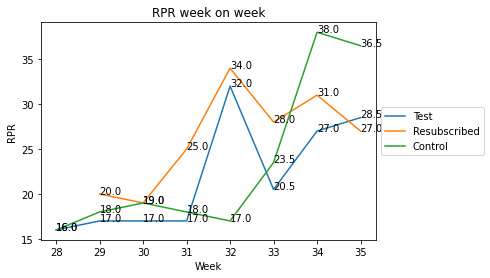

In [376]:
# Median RPR

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['rides'].median())
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['rides'].median())
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in df_control['week'].unique():
    y_control.append(df_control[df_control['week'] == w]['rides'].median())
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1   

i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1   
    
plt.xlabel("Week")
plt.ylabel("RPR")
plt.title("RPR week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

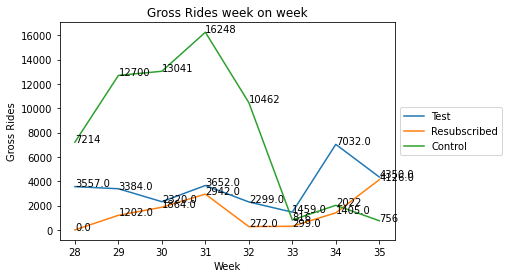

In [377]:
# Gross Rides

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['rides'].sum())
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['rides'].sum())

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in df_control['week'].unique():
    y_control.append(df_control[df_control['week'] == w]['rides'].sum())
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1
    
i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

plt.xlabel("Week")
plt.ylabel("Gross Rides")
plt.title("Gross Rides week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

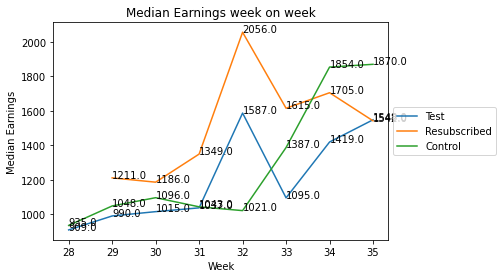

In [378]:
# Median Earnings

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(round(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['orders_earnings'].median(),0))
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(round(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['orders_earnings'].median(),0))

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')
    
y_control = []

for w in df_control['week'].unique():
    y_control.append(round(df_control[df_control['week'] == w]['orders_earnings'].median(),0))
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1
    
i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

plt.xlabel("Week")
plt.ylabel("Median Earnings")
plt.title("Median Earnings week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

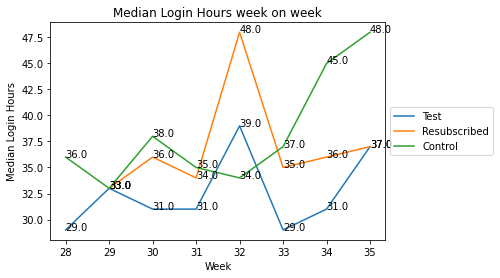

In [379]:
# Median Login hours

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(round(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['login_hours'].median(),0))
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(round(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['login_hours'].median(),0))

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in df_control['week'].unique():
    y_control.append(round(df_control[df_control['week'] == w]['login_hours'].median(),0))
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1    

plt.xlabel("Week")
plt.ylabel("Median Login Hours")
plt.title("Median Login Hours week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

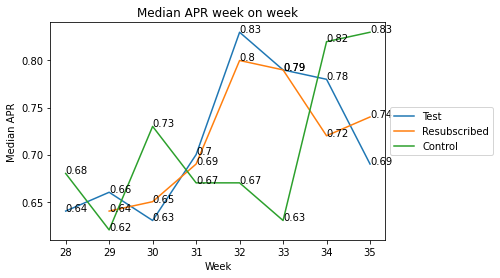

In [227]:
# APR

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(round(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['APR'].median(),2))
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(round(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['APR'].median(),2))

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')


y_control = []

for w in df_control['week'].unique():
    y_control.append(round(df_control[df_control['week'] == w]['APR'].median(),2))
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1    
    
    
plt.xlabel("Week")
plt.ylabel("Median APR")
plt.title("Median APR week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

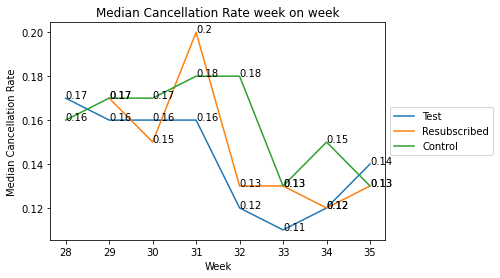

In [228]:
# Cancel Rate

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(round(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['cancel'].median(),2))
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(round(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['cancel'].median(),2))

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in df_control['week'].unique():
    y_control.append(round(df_control[df_control['week'] == w]['cancel'].median(),2))
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1
                                
i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

plt.xlabel("Week")
plt.ylabel("Median Cancellation Rate")
plt.title("Median Cancellation Rate week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

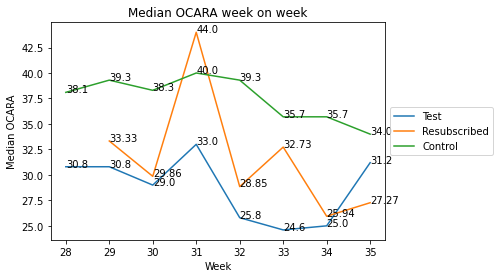

In [229]:
# OCARA

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(round(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['ocara'].median(),1))
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(round(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['ocara'].median(),2))

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in df_control['week'].unique():
    y_control.append(round(df_control[df_control['week'] == w]['ocara'].median(),1))
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1
    
i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

plt.xlabel("Week")
plt.ylabel("Median OCARA")
plt.title("Median OCARA week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

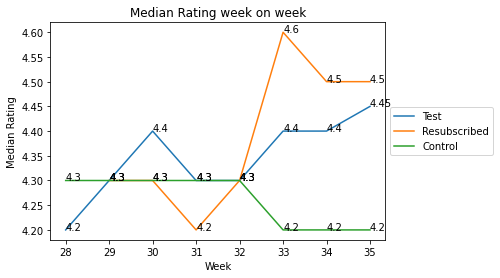

In [230]:
# Median Rating

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['rating'].median())
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['rating'].median())

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in df_control['week'].unique():
    y_control.append(df_control[df_control['week'] == w]['rating'].median())
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1
    
i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

plt.xlabel("Week")
plt.ylabel("Median Rating")
plt.title("Median Rating week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

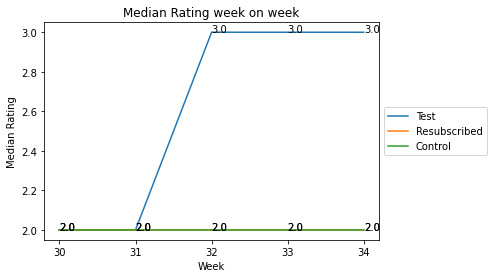

In [58]:
# Median Level

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['priority'].median())
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['priority'].median())

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in df_control['week'].unique():
    y_control.append(df_control[df_control['week'] == w]['priority'].median())
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1
    
i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

plt.xlabel("Week")
plt.ylabel("Median Rating")
plt.title("Median Rating week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

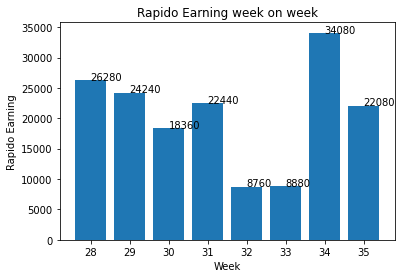

In [380]:
# Rapido Earning from Subscription

fig = plt.figure()
ax = fig.add_subplot(111)

y = []

for w in df_test['week'].unique():
    y.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['captainid'].nunique()*120)
    
plt.bar(np.sort(df_test['week'].unique().astype(str)), y, label = 'Test')

plt.xlabel("Week")
plt.ylabel("Rapido Earning")
plt.title("Rapido Earning week on week")
#plt.legend(loc="best")

for i in range(len(np.sort(df_test['week'].unique()))):
    plt.text(i,y[i],y[i])
    
plt.show()

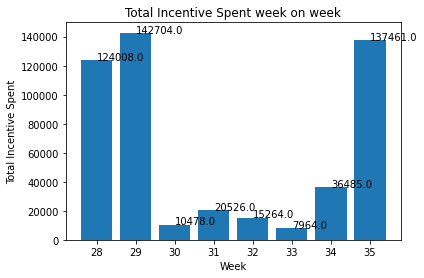

In [381]:
# Incentive Spent for Subscription Captains

y = []

for w in df_test['week'].unique():
    y.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['total_incentive'].sum())
    
plt.bar(np.sort(df_test['week'].unique().astype(str)), y, label = 'Test')

plt.xlabel("Week")
plt.ylabel("Total Incentive Spent")
plt.title("Total Incentive Spent week on week")
#plt.legend(loc="best")

for i in range(len(np.sort(df_test['week'].unique()))):
    plt.text(i,y[i],y[i])
    
plt.show()

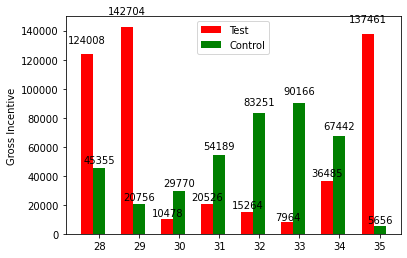

In [382]:
# Gross Incentive paid to captains

N = 8
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []
for w in np.sort(df_test['week'].unique()):
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['total_incentive'].sum())
    
rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')

y_control = []
for w in np.sort(df_control['week'].unique()):
    y_control.append(df_control[(df_control['week'] == w)]['total_incentive'].sum())

rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Gross Incentive')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

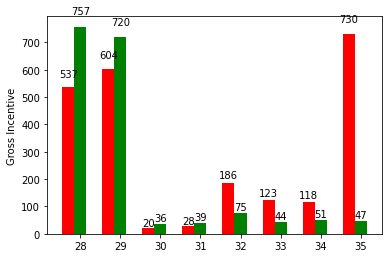

In [383]:
# Median Incentive paid to captains

N = 8
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []
for w in np.sort(df_test['week'].unique()):
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['total_incentive'].median())
    
rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')

y_control = []
for w in np.sort(df_control['week'].unique()):
    y_control.append(df_control[(df_control['week'] == w)]['total_incentive'].median())

rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Gross Incentive')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
#ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

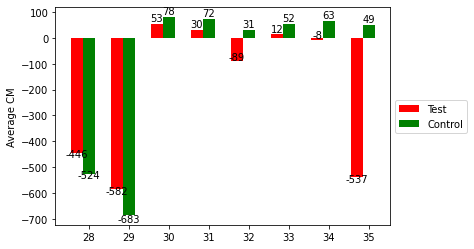

In [384]:
# Mean CM 

N = 8
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []
for w in np.sort(df_test['week'].unique()):
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['cm'].mean())
    
rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')

y_control = []
for w in np.sort(df_control['week'].unique()):
    y_control.append(df_control[(df_control['week'] == w)]['cm'].mean())

rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Average CM')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

In [240]:
for w in df_test['week'].unique():
    df_temp = df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]
    print('Week : ',w, ' GMV : ', round(df_temp['orders_earnings'].sum(),0), ' Subscription Received : ', df_temp['captainid'].nunique()*120, ' Incentive Spent : ',df_temp['total_incentive'].sum(),' Customer Discounts : ',df_temp['discount'].sum(), ' CM % : ', round((df_temp['captainid'].nunique()*120 - df_temp['total_incentive'].sum()) /df_temp['orders_earnings'].sum()*100.0,1))


Week :  28  GMV :  206885.0  Subscription Received :  26280  Incentive Spent :  341.0  Customer Discounts :  16781.0  CM % :  12.5
Week :  29  GMV :  191745.0  Subscription Received :  23760  Incentive Spent :  366.0  Customer Discounts :  13948.0  CM % :  12.2
Week :  30  GMV :  133295.0  Subscription Received :  18120  Incentive Spent :  9438.0  Customer Discounts :  13647.0  CM % :  6.5
Week :  31  GMV :  175842.0  Subscription Received :  22440  Incentive Spent :  16064.0  Customer Discounts :  25110.0  CM % :  3.6
Week :  32  GMV :  123266.0  Subscription Received :  8760  Incentive Spent :  14577.0  Customer Discounts :  15976.0  CM % :  -4.7
Week :  33  GMV :  77529.0  Subscription Received :  8880  Incentive Spent :  7516.0  Customer Discounts :  10892.0  CM % :  1.8
Week :  34  GMV :  369935.0  Subscription Received :  34080  Incentive Spent :  35198.0  Customer Discounts :  42028.0  CM % :  -0.3
Week :  35  GMV :  220125.0  Subscription Received :  21840  Incentive Spent :  3

In [241]:
for w in df_control['week'].unique():
    df_temp = df_control[(df_control['week'] == w)]
    print('Week : ',w, ' GMV : ', round(df_temp['orders_earnings'].sum(),0), ' Commission : ', round(df_temp['commission'].sum(),0), ' Incentive Spent : ',df_temp['total_incentive'].sum(),' Customer Discounts : ',df_temp['discount'].sum(), ' CM % : ', round((df_temp['commission'].sum() - df_temp['total_incentive'].sum()) /df_temp['orders_earnings'].sum()*100.0,1))


Week :  30  GMV :  425805.0  Commission :  62436.0  Incentive Spent :  21189.0  Customer Discounts :  51779.0  CM % :  9.7
Week :  34  GMV :  829059.0  Commission :  117928.0  Incentive Spent :  48427.0  Customer Discounts :  103317.0  CM % :  8.4
Week :  32  GMV :  756927.0  Commission :  102968.0  Incentive Spent :  65699.0  Customer Discounts :  99539.0  CM % :  4.9
Week :  33  GMV :  944685.0  Commission :  131671.0  Incentive Spent :  78709.0  Customer Discounts :  130525.0  CM % :  5.6
Week :  31  GMV :  685708.0  Commission :  104022.0  Incentive Spent :  51359.0  Customer Discounts :  100682.0  CM % :  7.7
Week :  35  GMV :  51627.0  Commission :  7251.0  Incentive Spent :  66.0  Customer Discounts :  6201.0  CM % :  13.9
Week :  28  GMV :  110130.0  Commission :  19331.0  Incentive Spent :  139.0  Customer Discounts :  9248.0  CM % :  17.4
Week :  29  GMV :  45390.0  Commission :  8399.0  Incentive Spent :  68.0  Customer Discounts :  3595.0  CM % :  18.4


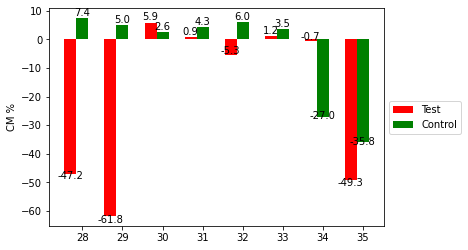

In [385]:
# CM %

N = 8
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []
for w in df_test['week'].unique():
    df_temp = df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]
    y_test.append(round((df_temp['captainid'].nunique()*120 - df_temp['total_incentive'].sum()) / df_temp['orders_earnings'].sum()*100.0,1))
    
rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')

y_control = []
for w in df_control['week'].unique():
    df_temp = df_control[df_control['week'] == w]
    y_control.append(round((df_temp['commission'].sum() - df_temp['total_incentive'].sum()) /df_temp['orders_earnings'].sum()*100.0,1))

rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('CM %')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

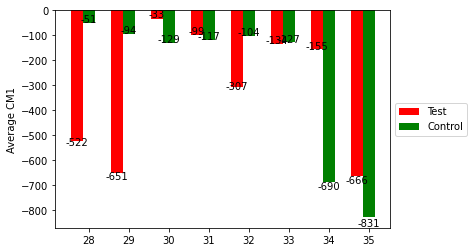

In [386]:
# Mean CM1

N = 8
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []
for w in df_test['week'].unique():
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['cm1'].mean())
    
rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')

y_control = []
for w in df_control['week'].unique():
    y_control.append(df_control[(df_control['week'] == w)]['cm1'].mean())

rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Average CM1')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

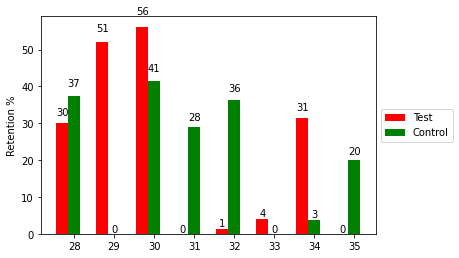

In [387]:
# Retention WoW for captains who subscribed and came to platform again and subscribed again

test_retention = df_test.copy()

y_test =[]
for w in test_retention['week'].unique():
    df_base = test_retention[(test_retention['week']==w) & (test_retention['interested']=='Yes')]
    df_next_week = test_retention[(test_retention['week']==w+1) & (test_retention['interested']=='Yes')]
    df_repeat = df_base.merge(df_next_week, how = 'inner', on = 'captainid')
    retention = df_repeat['captainid'].nunique() * 100.00 / df_base['captainid'].nunique()
    y_test.append(retention)
    

control_retention = df_control.copy()
y_control =[]
for w in control_retention['week'].unique():
    df_base = control_retention[(control_retention['week']==w)]
    df_next_week = control_retention[(control_retention['week']==w+1)]
    df_repeat = df_base.merge(df_next_week, how = 'inner', on = 'rider')
    retention = df_repeat['rider'].nunique() * 100.00 / df_base['rider'].nunique()
    y_control.append(retention)
    
N = 8
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')
rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Retention %')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

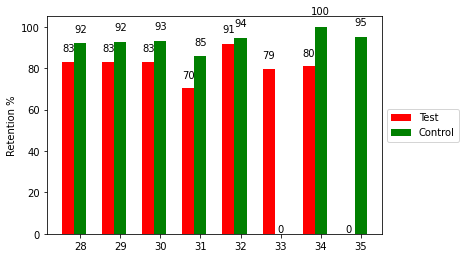

In [388]:
# Retention WoW for captains who subscribed and came to platform again but not subscribed

test_retention = df_test.copy()
df_temp = final_data.copy()

y_test =[]
for w in test_retention['week'].unique():
    df_base = test_retention[(test_retention['week']==w) & (test_retention['interested']=='Yes')]
    df_next_week = df_temp[df_temp['week']==w+1]
    df_repeat = df_base.merge(df_next_week, how = 'inner', left_on = 'captainid', right_on = 'rider')
    retention = df_repeat['captainid'].nunique() * 100.00 / df_base['captainid'].nunique()
    y_test.append(retention)
    

control_retention = df_control.copy()
df_temp = final_data.copy()

y_control =[]
for w in control_retention['week'].unique():
    df_base = control_retention[(control_retention['week']==w)]
    df_next_week = df_temp[df_temp['week']==w+1]['rider']
    df_repeat = df_base.merge(df_next_week, how = 'inner', on = 'rider')
    retention = df_repeat['rider'].nunique() * 100.00 / df_base['rider'].nunique()
    y_control.append(retention)
    
N = 8
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')
rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Retention %')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

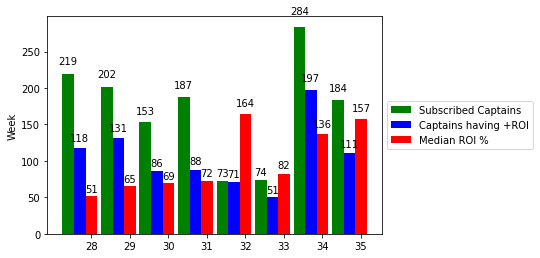

In [389]:
# ROI %

N = 8
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

y_interested_captains = []
for w in np.sort(df_test['week'].unique()):
    y_interested_captains.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['captainid'].nunique())

rects1 = ax.bar(ind-width, y_interested_captains, width, color='g',label = 'Subscribed Captains')

y_positive_roi = []
for w in np.sort(df_control['week'].unique()):
    y_positive_roi.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes') & (df_test['roi'] > 0)]['captainid'].nunique())

rects2 = ax.bar(ind, y_positive_roi, width, color='b',label = 'Captains having +ROI')

y_roi = []
for w in np.sort(df_test['week'].unique()):
    y_roi.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['roi'].median())
    
rects3 = ax.bar(ind+width, y_roi, width, color='r', label = 'Median ROI %')





ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
#ax.set_ylabel('Gross Incentive')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.show()

In [398]:
subscription_incentive = []
non_subscription_incentive = []

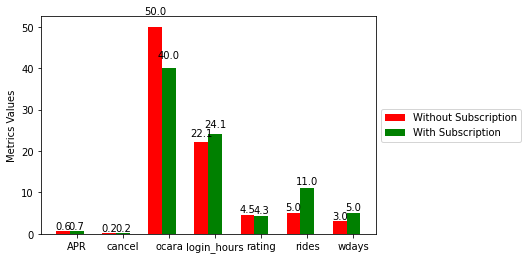

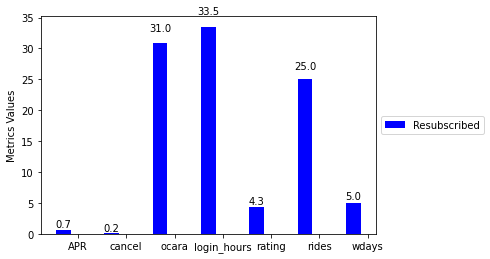

In [399]:
# Captains subscribe in w31 but not in week 30

df_31 = df_test[(df_test['week']==31)&(df_test['interested']=='Yes')]
df_30 = df_test[(df_test['week']==30)&(df_test['interested']=='Yes')]
df_captains = df_31.merge(df_30, how = 'outer', on = 'captainid', indicator=True)
df_captains = df_captains[df_captains['_merge']== 'left_only']
df_captains = df_captains[['captainid']]

#metrics for w30 and w31

metrics_30 = df_captains.merge(final_data[final_data['week']==30], how = 'left', left_on = 'captainid', right_on = 'rider')
metrics_31 = df_captains.merge(df_31, how = 'left', left_on = 'captainid', right_on = 'captainid')

w30 = []
w31 = []

w30.append(metrics_30['APR'].median())
w30.append(metrics_30['cancel'].median())
w30.append(metrics_30['ocara'].median())
w30.append(metrics_30['login_hours'].median())
w30.append(metrics_30['rating'].median())
w30.append(metrics_30['rides'].median())
w30.append(metrics_30['wdays'].median())

w31.append(metrics_31['APR'].median())
w31.append(metrics_31['cancel'].median())
w31.append(metrics_31['ocara'].median())
w31.append(metrics_31['login_hours'].median())
w31.append(metrics_31['rating'].median())
w31.append(metrics_31['rides'].median())
w31.append(metrics_31['wdays'].median())

non_subscription_incentive.append(metrics_30['orders_earnings'].median())
subscription_incentive.append(metrics_31['orders_earnings'].median())

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, w30, width, color='r', label = 'Without Subscription')
rects2 = ax.bar(ind+width, w31, width, color='g',label = 'With Subscription')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()


N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

df_resubscribed = df_test[(df_test['week']==31)&(df_test['resubscribed']=='Yes')]
w31 = []

w31.append(df_resubscribed['APR'].median())
w31.append(df_resubscribed['cancel'].median())
w31.append(df_resubscribed['ocara'].median())
w31.append(df_resubscribed['login_hours'].median())
w31.append(df_resubscribed['rating'].median())
w31.append(df_resubscribed['rides'].median())
w31.append(df_resubscribed['wdays'].median())


rects1 = ax.bar(ind, w31, width, color='b', label = 'Resubscribed')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

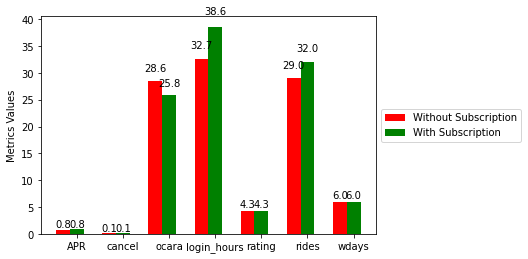

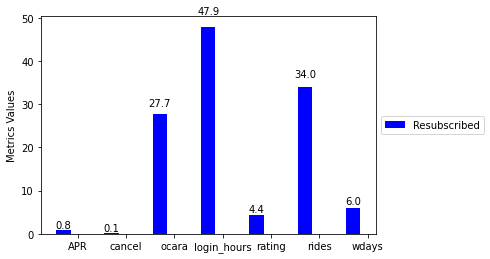

In [400]:
# Captains subscribe in w32 but not in week 31

df_32 = df_test[(df_test['week']==32)&(df_test['interested']=='Yes')]
df_31 = df_test[(df_test['week']==31)&(df_test['interested']=='Yes')]
df_captains = df_32.merge(df_31, how = 'outer', on = 'captainid', indicator=True)
df_captains = df_captains[df_captains['_merge']== 'left_only']
df_captains = df_captains[['captainid']]

#metrics for w31 and w32

metrics_31 = df_captains.merge(final_data[final_data['week']==31], how = 'left', left_on = 'captainid', right_on = 'rider')
metrics_32 = df_captains.merge(df_32, how = 'left', left_on = 'captainid', right_on = 'captainid')

w31 = []
w32 = []

w31.append(metrics_31['APR'].median())
w31.append(metrics_31['cancel'].median())
w31.append(metrics_31['ocara'].median())
w31.append(metrics_31['login_hours'].median())
w31.append(metrics_31['rating'].median())
w31.append(metrics_31['rides'].median())
w31.append(metrics_31['wdays'].median())

w32.append(metrics_32['APR'].median())
w32.append(metrics_32['cancel'].median())
w32.append(metrics_32['ocara'].median())
w32.append(metrics_32['login_hours'].median())
w32.append(metrics_32['rating'].median())
w32.append(metrics_32['rides'].median())
w32.append(metrics_32['wdays'].median())

non_subscription_incentive.append(metrics_31['orders_earnings'].median())
subscription_incentive.append(metrics_32['orders_earnings'].median())

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, w31, width, color='r', label = 'Without Subscription')
rects2 = ax.bar(ind+width, w32, width, color='g',label = 'With Subscription')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

df_resubscribed = df_test[(df_test['week']==32)&(df_test['resubscribed']=='Yes')]
w31 = []

w31.append(df_resubscribed['APR'].median())
w31.append(df_resubscribed['cancel'].median())
w31.append(df_resubscribed['ocara'].median())
w31.append(df_resubscribed['login_hours'].median())
w31.append(df_resubscribed['rating'].median())
w31.append(df_resubscribed['rides'].median())
w31.append(df_resubscribed['wdays'].median())


rects1 = ax.bar(ind, w31, width, color='b', label = 'Resubscribed')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

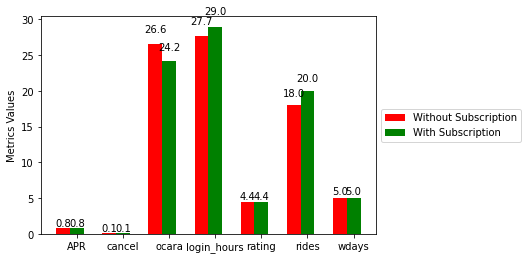

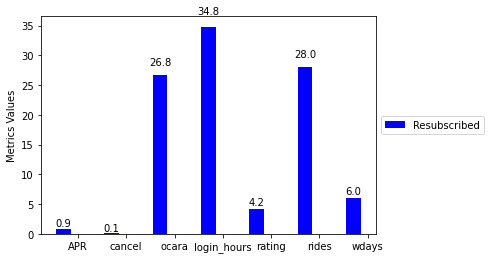

In [401]:
# Captains subscribe in w33 but not in week 32

df_33 = df_test[(df_test['week']==33)&(df_test['interested']=='Yes')]
df_32 = df_test[(df_test['week']==32)&(df_test['interested']=='Yes')]
df_captains = df_33.merge(df_32, how = 'outer', on = 'captainid', indicator=True)
df_captains = df_captains[df_captains['_merge']== 'left_only']
df_captains = df_captains[['captainid']]

#metrics for w32 and w33

metrics_32 = df_captains.merge(final_data[final_data['week']==32], how = 'left', left_on = 'captainid', right_on = 'rider')
metrics_33 = df_captains.merge(df_33, how = 'left', left_on = 'captainid', right_on = 'captainid')

w32 = []
w33 = []

w32.append(metrics_32['APR'].median())
w32.append(metrics_32['cancel'].median())
w32.append(metrics_32['ocara'].median())
w32.append(metrics_32['login_hours'].median())
w32.append(metrics_32['rating'].median())
w32.append(metrics_32['rides'].median())
w32.append(metrics_32['wdays'].median())

w33.append(metrics_33['APR'].median())
w33.append(metrics_33['cancel'].median())
w33.append(metrics_33['ocara'].median())
w33.append(metrics_33['login_hours'].median())
w33.append(metrics_33['rating'].median())
w33.append(metrics_33['rides'].median())
w33.append(metrics_33['wdays'].median())

non_subscription_incentive.append(metrics_32['orders_earnings'].median())
subscription_incentive.append(metrics_33['orders_earnings'].median())

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, w32, width, color='r', label = 'Without Subscription')
rects2 = ax.bar(ind+width, w33, width, color='g',label = 'With Subscription')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

df_resubscribed = df_test[(df_test['week']==33)&(df_test['resubscribed']=='Yes')]
w31 = []

w31.append(df_resubscribed['APR'].median())
w31.append(df_resubscribed['cancel'].median())
w31.append(df_resubscribed['ocara'].median())
w31.append(df_resubscribed['login_hours'].median())
w31.append(df_resubscribed['rating'].median())
w31.append(df_resubscribed['rides'].median())
w31.append(df_resubscribed['wdays'].median())


rects1 = ax.bar(ind, w31, width, color='b', label = 'Resubscribed')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

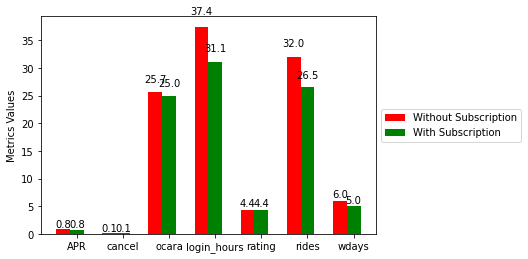

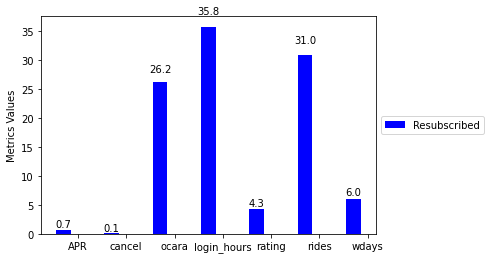

In [402]:
# Captains subscribe in w34 but not in week 33

df_34 = df_test[(df_test['week']==34)&(df_test['interested']=='Yes')]
df_33 = df_test[(df_test['week']==33)&(df_test['interested']=='Yes')]
df_captains = df_34.merge(df_33, how = 'outer', on = 'captainid', indicator=True)
df_captains = df_captains[df_captains['_merge']== 'left_only']
df_captains = df_captains[['captainid']]

#metrics for w32 and w33

metrics_33 = df_captains.merge(final_data[final_data['week']==33], how = 'left', left_on = 'captainid', right_on = 'rider')
metrics_34 = df_captains.merge(df_34, how = 'left', left_on = 'captainid', right_on = 'captainid')

w33 = []
w34 = []

w33.append(metrics_33['APR'].median())
w33.append(metrics_33['cancel'].median())
w33.append(metrics_33['ocara'].median())
w33.append(metrics_33['login_hours'].median())
w33.append(metrics_33['rating'].median())
w33.append(metrics_33['rides'].median())
w33.append(metrics_33['wdays'].median())

w34.append(metrics_34['APR'].median())
w34.append(metrics_34['cancel'].median())
w34.append(metrics_34['ocara'].median())
w34.append(metrics_34['login_hours'].median())
w34.append(metrics_34['rating'].median())
w34.append(metrics_34['rides'].median())
w34.append(metrics_34['wdays'].median())

non_subscription_incentive.append(metrics_33['orders_earnings'].median())
subscription_incentive.append(metrics_34['orders_earnings'].median())

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, w33, width, color='r', label = 'Without Subscription')
rects2 = ax.bar(ind+width, w34, width, color='g',label = 'With Subscription')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

df_resubscribed = df_test[(df_test['week']==34)&(df_test['resubscribed']=='Yes')]
w31 = []

w31.append(df_resubscribed['APR'].median())
w31.append(df_resubscribed['cancel'].median())
w31.append(df_resubscribed['ocara'].median())
w31.append(df_resubscribed['login_hours'].median())
w31.append(df_resubscribed['rating'].median())
w31.append(df_resubscribed['rides'].median())
w31.append(df_resubscribed['wdays'].median())


rects1 = ax.bar(ind, w31, width, color='b', label = 'Resubscribed')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

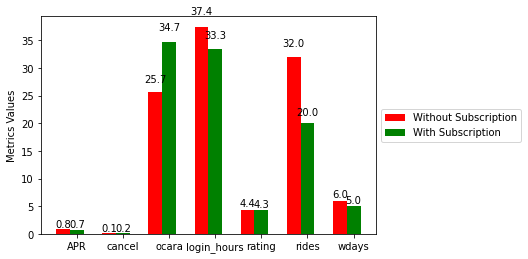

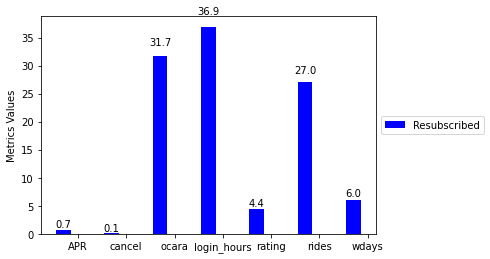

In [403]:
# Captains subscribe in w35 but not in week 34

df_35 = df_test[(df_test['week']==35)&(df_test['interested']=='Yes')]
df_34 = df_test[(df_test['week']==34)&(df_test['interested']=='Yes')]
df_captains = df_35.merge(df_34, how = 'outer', on = 'captainid', indicator=True)
df_captains = df_captains[df_captains['_merge']== 'left_only']
df_captains = df_captains[['captainid']]

#metrics for w32 and w33

metrics_34 = df_captains.merge(final_data[final_data['week']==34], how = 'left', left_on = 'captainid', right_on = 'rider')
metrics_35 = df_captains.merge(df_35, how = 'left', left_on = 'captainid', right_on = 'captainid')

w34 = []
w35 = []

w34.append(metrics_34['APR'].median())
w34.append(metrics_34['cancel'].median())
w34.append(metrics_34['ocara'].median())
w34.append(metrics_34['login_hours'].median())
w34.append(metrics_34['rating'].median())
w34.append(metrics_34['rides'].median())
w34.append(metrics_34['wdays'].median())

w35.append(metrics_35['APR'].median())
w35.append(metrics_35['cancel'].median())
w35.append(metrics_35['ocara'].median())
w35.append(metrics_35['login_hours'].median())
w35.append(metrics_35['rating'].median())
w35.append(metrics_35['rides'].median())
w35.append(metrics_35['wdays'].median())

non_subscription_incentive.append(metrics_34['orders_earnings'].median())
subscription_incentive.append(metrics_35['orders_earnings'].median())

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, w33, width, color='r', label = 'Without Subscription')
rects2 = ax.bar(ind+width, w34, width, color='g',label = 'With Subscription')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

df_resubscribed = df_test[(df_test['week']==35)&(df_test['resubscribed']=='Yes')]
w31 = []

w31.append(df_resubscribed['APR'].median())
w31.append(df_resubscribed['cancel'].median())
w31.append(df_resubscribed['ocara'].median())
w31.append(df_resubscribed['login_hours'].median())
w31.append(df_resubscribed['rating'].median())
w31.append(df_resubscribed['rides'].median())
w31.append(df_resubscribed['wdays'].median())


rects1 = ax.bar(ind, w31, width, color='b', label = 'Resubscribed')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

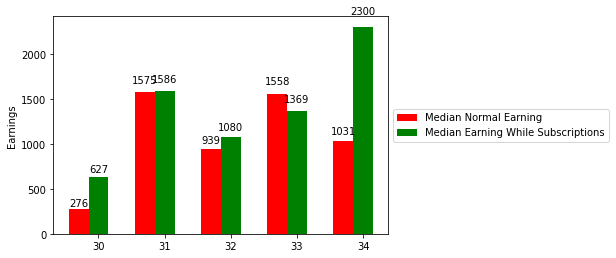

In [405]:
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, non_subscription_incentive, width, color='r', label = 'Median Normal Earning')
rects2 = ax.bar(ind+width, subscription_incentive, width, color='g',label = 'Median Earning While Subscriptions')

ax.set_xticklabels([30,31,32,33,34,35])
ax.set_ylabel('Week')
ax.set_ylabel('Earnings')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

In [184]:
# captains interested but not done any rides

total_captains = df_test[(df_test['week']==30) & (df_test['interested']=='Yes')]['captainid'].nunique()
zero_rides = df_test[(df_test['week']==30) & (df_test['interested']=='Yes') & (df_test['rides'].isna())]['captainid'].nunique()
print('Total captains : ', total_captains)
print('captain subscribed but doing 0 rides : ', zero_rides)

Total captains :  151
captain subscribed but doing 0 rides :  24


In [218]:
# Retention WoW for captains who subscribed and came to platform again and subscribed again

test_retention = df_test.copy()

y_test =[]
for w in test_retention['week'].unique():
    df_base = test_retention[(test_retention['week']==w) & (test_retention['interested']=='Yes')]
    tot_captains = df_base['captainid'].nunique()
    median_incentive = df_base['total_incentive'].median()
    incentive_received = df_base['total_incentive'].notna().sum()
    df_next_week = test_retention[(test_retention['week'] > w) & (test_retention['resubscribed']=='Yes')]
    df_repeat = df_base.merge(df_next_week, how = 'inner', on = 'captainid')
    retention = df_repeat['captainid'].nunique() ##* 100.00 / df_base['captainid'].nunique()
    print('Week : ',w, ' Total subscription Captains : ',tot_captains, ' Median Incentive : ', median_incentive, ' Captains Received Incentive : ', incentive_received, ' Incentive Achieved Percent : ', round(incentive_received*100.0/tot_captains,0),'%',' Resubscribed Captains : ', retention)

Week :  30  Total subscription Captains :  151  Median Incentive :  198.0  Captains Received Incentive :  45  Incentive Achieved Percent :  30.0 %  Resubscribed Captains :  46
Week :  31  Total subscription Captains :  187  Median Incentive :  207.0  Captains Received Incentive :  62  Incentive Achieved Percent :  33.0 %  Resubscribed Captains :  4
Week :  32  Total subscription Captains :  73  Median Incentive :  252.0  Captains Received Incentive :  52  Incentive Achieved Percent :  71.0 %  Resubscribed Captains :  1
Week :  33  Total subscription Captains :  74  Median Incentive :  150.0  Captains Received Incentive :  35  Incentive Achieved Percent :  47.0 %  Resubscribed Captains :  0


In [220]:
# Retention WoW for captains who subscribed and came to platform again and subscribed again

test_retention = df_test.copy()

y_test =[]
for w in test_retention['week'].unique():
    df_base = test_retention[(test_retention['week']==w) & (test_retention['resubscribed']=='Yes')]
    tot_captains = df_base['captainid'].nunique()
    median_incentive = df_base['total_incentive'].median()
    incentive_received = df_base['total_incentive'].notna().sum()
    df_next_week = test_retention[(test_retention['week'] > w) & (test_retention['resubscribed']=='Yes')]
    df_repeat = df_base.merge(df_next_week, how = 'inner', on = 'captainid')
    retention = df_repeat['captainid'].nunique() ##* 100.00 / df_base['captainid'].nunique()
    print('Week : ',w, ' Total subscription Captains : ',tot_captains, ' Median Incentive : ', median_incentive, ' Captains Received Incentive : ', incentive_received, ' Incentive Achieved Percent : ', round(incentive_received*100.0/tot_captains,0),'%',' Resubscribed Captains : ', retention)

Week :  30  Total subscription Captains :  152  Median Incentive :  229.0  Captains Received Incentive :  44  Incentive Achieved Percent :  29.0 %  Resubscribed Captains :  41
Week :  31  Total subscription Captains :  47  Median Incentive :  258.0  Captains Received Incentive :  17  Incentive Achieved Percent :  36.0 %  Resubscribed Captains :  1
Week :  32  Total subscription Captains :  8  Median Incentive :  290.0  Captains Received Incentive :  4  Incentive Achieved Percent :  50.0 %  Resubscribed Captains :  0
Week :  33  Total subscription Captains :  10  Median Incentive :  204.0  Captains Received Incentive :  9  Incentive Achieved Percent :  90.0 %  Resubscribed Captains :  0


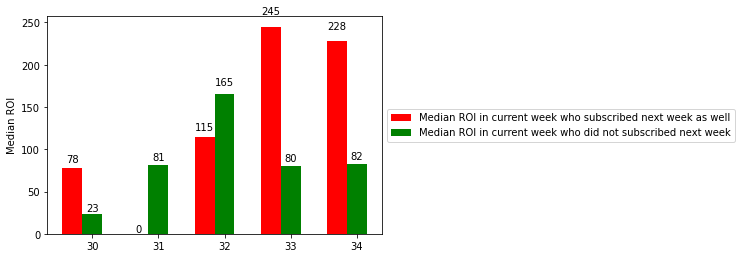

In [307]:
# Behaviour of Subscription captains
x = []
y = []

df1 = df_test[(df_test['week'] == 30) & (df_test['interested'] == 'Yes')]    #current week
df2 = df_test[(df_test['week'] == 31) & (df_test['interested'] == 'Yes')]['captainid']    #Next week
df3 = df1.merge(df2, how='left',on = 'captainid',indicator=True)
x.append(round(df3[df3['_merge'] == 'both']['roi'].median(),0))
y.append(round(df3[df3['_merge'] == 'left_only']['roi'].median(),0))

df1 = df_test[(df_test['week'] == 31) & (df_test['interested'] == 'Yes')]    #current week
df2 = df_test[(df_test['week'] == 32) & (df_test['interested'] == 'Yes')]['captainid']    #Next week
df3 = df1.merge(df2, how='left',on = 'captainid',indicator=True)
x.append(round(df3[df3['_merge'] == 'both']['roi'].median(),0))
y.append(round(df3[df3['_merge'] == 'left_only']['roi'].median(),0))

df1 = df_test[(df_test['week'] == 32) & (df_test['interested'] == 'Yes')]    #current week
df2 = df_test[(df_test['week'] == 33) & (df_test['interested'] == 'Yes')]['captainid']    #Next week
df3 = df1.merge(df2, how='left',on = 'captainid',indicator=True)
x.append(round(df3[df3['_merge'] == 'both']['roi'].median(),0))
y.append(round(df3[df3['_merge'] == 'left_only']['roi'].median(),0))

df1 = df_test[(df_test['week'] == 33) & (df_test['interested'] == 'Yes')]    #current week
df2 = df_test[(df_test['week'] == 34) & (df_test['interested'] == 'Yes')]['captainid']    #Next week
df3 = df1.merge(df2, how='left',on = 'captainid',indicator=True)
x.append(round(df3[df3['_merge'] == 'both']['roi'].median(),0))
y.append(round(df3[df3['_merge'] == 'left_only']['roi'].median(),0))

df1 = df_test[(df_test['week'] == 34) & (df_test['interested'] == 'Yes')]    #current week
df2 = df_test[(df_test['week'] == 35) & (df_test['interested'] == 'Yes')]['captainid']    #Next week
df3 = df1.merge(df2, how='left',on = 'captainid',indicator=True)
x.append(round(df3[df3['_merge'] == 'both']['roi'].median(),0))
y.append(round(df3[df3['_merge'] == 'left_only']['roi'].median(),0))

x = [0 if a != a else a for a in x]
y = [0 if a != a else a for a in y]



N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, x, width, color='r', label = 'Median ROI in current week who subscribed next week as well')
rects2 = ax.bar(ind+width, y, width, color='g',label = 'Median ROI in current week who did not subscribed next week')

ax.set_xticklabels([30,31,32,33,34,35])
ax.set_ylabel('Week')
ax.set_ylabel('Median ROI')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

In [22]:
df_original = df_test.copy()

In [483]:
df_test['week'].unique()

array([28, 29, 30, 31, 32, 33, 34, 35])

In [24]:
df_segment = pd.read_csv('Captain_Segment_Jaipur.csv')
df_segment['week'].unique()

array([35, 34, 36])

In [25]:
df_test = df_test[df_test['week'] >= 36]
df_segment = df_segment[df_segment['week'] >= 36]

In [26]:
df_test = df_test.merge(df_segment[['RIDER','week','Segment']], how = 'left', left_on = ['captainid','week'], right_on = ['RIDER', 'week'])

In [488]:
df_test.head()

,mobile,week,interested,captainid,wdays,rides,rating,commission,discount,login_hours,...,daily_incentive,weekly_incentive,total_incentive,ltr,resubscribed,cm,cm1,roi,RIDER,Segment
0,7014500093,34,Yes,5ca995f954bc7263ff2ba705,1.0,3.0,5.0,0.000,0.0,7.994130,...,0.0,0.0,0.0,123.0,,120.0,120.0,-69.753333,5ca995f954bc7263ff2ba705,LP_D_HO
1,9785238501,34,Yes,5f2e4e5b390eff464beab99f,0.0,0.0,0.0,0.000,0.0,0.000000,...,0.0,0.0,0.0,0.0,,120.0,120.0,-100.000000,5f2e4e5b390eff464beab99f,LP_D_HO
2,6375686504,34,Yes,5d25797e06ee2c37f1efeef5,2.0,6.0,3.7,7.794,24.0,20.572151,...,8.0,0.0,8.0,357.0,,112.0,88.0,-64.870000,5d25797e06ee2c37f1efeef5,LP_D_HO
3,9782234036,34,Yes,5d0b41d41c64cc470f6528de,5.0,53.0,4.3,0.000,338.0,30.283482,...,80.0,220.0,300.0,1589.0,Yes,-180.0,-518.0,320.105000,5d0b41d41c64cc470f6528de,HP_D_HO
4,9057519139,34,Yes,5bb30d4b7e7bc30a383775f8,7.0,37.0,3.8,3.840,195.0,55.327304,...,96.0,180.0,276.0,1053.0,,-156.0,-351.0,203.388333,5bb30d4b7e7bc30a383775f8,LP_D_MO


In [45]:
df_test.pivot_table(index='Segment', columns = 'week', values = 'login_hours', aggfunc = 'mean').sort_values('Segment')

week,36
Segment,
HP_D_HO,58.191199
HP_D_UHO,63.084688
LP_D_HO,35.544765
LP_D_LO,9.552337
LP_D_MO,19.222612
LP_D_UHO,37.718647
LP_Inter_LO,0.518716
LP_Intra_HO,33.317508
LP_Intra_LO,7.885961


In [503]:
df_final = final_data[final_data['week'] >= 34]

In [504]:
df_final['cm'] = df_final['commission'] - df_final['total_incentive']
df_final['cm1'] = df_final['cm'] - df_final['discount']

In [506]:
df_final = df_final.merge(df_segment[['RIDER','week','Segment']], how = 'left', left_on = ['rider','week'], right_on = ['RIDER', 'week'])

In [27]:
df_control = df_control.merge(df_segment[['RIDER','week','Segment']], how = 'left', left_on = ['rider','week'], right_on = ['RIDER', 'week'])

In [58]:
df_control.pivot_table(index='Segment', columns = 'week', values = 'login_hours', aggfunc = 'mean').sort_values('Segment')

week,36
Segment,
HP_D_HO,35.609421
HP_D_UHO,38.847886
LP_D_HO,24.197234
LP_D_LO,10.009302
LP_D_MO,15.975109
LP_D_UHO,34.716455
LP_Inter_HO,14.591891
LP_Inter_LO,3.843143
LP_Inter_MO,6.963776
